## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
#         out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
# #         out = self.bn3(out)
#         out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 1200    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-7)

In [11]:
train_loss_avg = []
test_losses = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
    
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    mu_z, std_z = encoder(X_test)
    
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = decoder(z_samples)
    eps = torch.randn_like(std_x)

    loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)

    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))
    print("Epoch [%d / %d] test loss: %f" % (ep+1, N_EPOCHS, test_losses[-1]))

Epoch [1 / 1200] average loss: 25.597570
Epoch [1 / 1200] test loss: 24.809198
Epoch [2 / 1200] average loss: 24.051956
Epoch [2 / 1200] test loss: 24.343946
Epoch [3 / 1200] average loss: 23.603130
Epoch [3 / 1200] test loss: 24.662345
Epoch [4 / 1200] average loss: 25.084145
Epoch [4 / 1200] test loss: 26.193193
Epoch [5 / 1200] average loss: 23.519565
Epoch [5 / 1200] test loss: 23.771573
Epoch [6 / 1200] average loss: 23.498981
Epoch [6 / 1200] test loss: 23.848869
Epoch [7 / 1200] average loss: 22.829448
Epoch [7 / 1200] test loss: 23.275625
Epoch [8 / 1200] average loss: 23.026310
Epoch [8 / 1200] test loss: 22.294343
Epoch [9 / 1200] average loss: 22.744145
Epoch [9 / 1200] test loss: 22.006438
Epoch [10 / 1200] average loss: 22.425819
Epoch [10 / 1200] test loss: 22.195646
Epoch [11 / 1200] average loss: 22.202456
Epoch [11 / 1200] test loss: 22.596498
Epoch [12 / 1200] average loss: 21.925766
Epoch [12 / 1200] test loss: 21.749838
Epoch [13 / 1200] average loss: 21.743644
Epoc

Epoch [117 / 1200] average loss: 15.692344
Epoch [117 / 1200] test loss: 15.561749
Epoch [118 / 1200] average loss: 15.689857
Epoch [118 / 1200] test loss: 15.392739
Epoch [119 / 1200] average loss: 15.805028
Epoch [119 / 1200] test loss: 15.319826
Epoch [120 / 1200] average loss: 15.543480
Epoch [120 / 1200] test loss: 15.561153
Epoch [121 / 1200] average loss: 15.515258
Epoch [121 / 1200] test loss: 15.329897
Epoch [122 / 1200] average loss: 15.577035
Epoch [122 / 1200] test loss: 15.268229
Epoch [123 / 1200] average loss: 15.616672
Epoch [123 / 1200] test loss: 15.205450
Epoch [124 / 1200] average loss: 15.363191
Epoch [124 / 1200] test loss: 15.192124
Epoch [125 / 1200] average loss: 15.426717
Epoch [125 / 1200] test loss: 15.140734
Epoch [126 / 1200] average loss: 15.386532
Epoch [126 / 1200] test loss: 15.035402
Epoch [127 / 1200] average loss: 15.226015
Epoch [127 / 1200] test loss: 15.171616
Epoch [128 / 1200] average loss: 15.252707
Epoch [128 / 1200] test loss: 14.869942
Epoc

Epoch [222 / 1200] average loss: 11.678703
Epoch [222 / 1200] test loss: 11.374511
Epoch [223 / 1200] average loss: 11.673032
Epoch [223 / 1200] test loss: 11.404939
Epoch [224 / 1200] average loss: 11.724422
Epoch [224 / 1200] test loss: 11.372659
Epoch [225 / 1200] average loss: 11.685221
Epoch [225 / 1200] test loss: 11.392373
Epoch [226 / 1200] average loss: 11.683221
Epoch [226 / 1200] test loss: 11.099400
Epoch [227 / 1200] average loss: 11.613379
Epoch [227 / 1200] test loss: 11.182698
Epoch [228 / 1200] average loss: 11.590575
Epoch [228 / 1200] test loss: 11.260294
Epoch [229 / 1200] average loss: 11.641959
Epoch [229 / 1200] test loss: 11.415808
Epoch [230 / 1200] average loss: 11.487217
Epoch [230 / 1200] test loss: 11.261675
Epoch [231 / 1200] average loss: 11.534282
Epoch [231 / 1200] test loss: 10.990989
Epoch [232 / 1200] average loss: 11.475633
Epoch [232 / 1200] test loss: 11.310275
Epoch [233 / 1200] average loss: 11.462975
Epoch [233 / 1200] test loss: 11.105547
Epoc

Epoch [331 / 1200] average loss: 9.854521
Epoch [331 / 1200] test loss: 9.267374
Epoch [332 / 1200] average loss: 9.741387
Epoch [332 / 1200] test loss: 9.335008
Epoch [333 / 1200] average loss: 9.625674
Epoch [333 / 1200] test loss: 9.313498
Epoch [334 / 1200] average loss: 9.718443
Epoch [334 / 1200] test loss: 9.217295
Epoch [335 / 1200] average loss: 9.663107
Epoch [335 / 1200] test loss: 9.317610
Epoch [336 / 1200] average loss: 9.496961
Epoch [336 / 1200] test loss: 9.173053
Epoch [337 / 1200] average loss: 9.545966
Epoch [337 / 1200] test loss: 9.183625
Epoch [338 / 1200] average loss: 9.484247
Epoch [338 / 1200] test loss: 9.149639
Epoch [339 / 1200] average loss: 9.549853
Epoch [339 / 1200] test loss: 9.256474
Epoch [340 / 1200] average loss: 9.534840
Epoch [340 / 1200] test loss: 9.085864
Epoch [341 / 1200] average loss: 9.509578
Epoch [341 / 1200] test loss: 9.209113
Epoch [342 / 1200] average loss: 9.461403
Epoch [342 / 1200] test loss: 9.186053
Epoch [343 / 1200] average l

Epoch [439 / 1200] average loss: 8.609687
Epoch [439 / 1200] test loss: 8.114097
Epoch [440 / 1200] average loss: 8.457328
Epoch [440 / 1200] test loss: 8.056855
Epoch [441 / 1200] average loss: 8.514858
Epoch [441 / 1200] test loss: 8.073151
Epoch [442 / 1200] average loss: 8.428266
Epoch [442 / 1200] test loss: 8.252806
Epoch [443 / 1200] average loss: 8.448301
Epoch [443 / 1200] test loss: 8.103735
Epoch [444 / 1200] average loss: 8.467877
Epoch [444 / 1200] test loss: 8.062860
Epoch [445 / 1200] average loss: 8.480399
Epoch [445 / 1200] test loss: 8.200146
Epoch [446 / 1200] average loss: 8.308899
Epoch [446 / 1200] test loss: 8.109233
Epoch [447 / 1200] average loss: 8.384414
Epoch [447 / 1200] test loss: 8.137996
Epoch [448 / 1200] average loss: 8.400257
Epoch [448 / 1200] test loss: 8.190329
Epoch [449 / 1200] average loss: 8.300346
Epoch [449 / 1200] test loss: 8.006850
Epoch [450 / 1200] average loss: 8.449704
Epoch [450 / 1200] test loss: 8.032337
Epoch [451 / 1200] average l

Epoch [547 / 1200] average loss: 7.508904
Epoch [547 / 1200] test loss: 6.946172
Epoch [548 / 1200] average loss: 7.540383
Epoch [548 / 1200] test loss: 7.058714
Epoch [549 / 1200] average loss: 7.634538
Epoch [549 / 1200] test loss: 7.152932
Epoch [550 / 1200] average loss: 7.412813
Epoch [550 / 1200] test loss: 6.981646
Epoch [551 / 1200] average loss: 7.480915
Epoch [551 / 1200] test loss: 7.060673
Epoch [552 / 1200] average loss: 7.442635
Epoch [552 / 1200] test loss: 7.109225
Epoch [553 / 1200] average loss: 7.459235
Epoch [553 / 1200] test loss: 7.139896
Epoch [554 / 1200] average loss: 7.439353
Epoch [554 / 1200] test loss: 7.050778
Epoch [555 / 1200] average loss: 7.459767
Epoch [555 / 1200] test loss: 6.925702
Epoch [556 / 1200] average loss: 7.399748
Epoch [556 / 1200] test loss: 7.008545
Epoch [557 / 1200] average loss: 7.338726
Epoch [557 / 1200] test loss: 6.991846
Epoch [558 / 1200] average loss: 7.443069
Epoch [558 / 1200] test loss: 7.059256
Epoch [559 / 1200] average l

Epoch [654 / 1200] average loss: 6.793582
Epoch [654 / 1200] test loss: 6.560975
Epoch [655 / 1200] average loss: 6.724299
Epoch [655 / 1200] test loss: 6.542947
Epoch [656 / 1200] average loss: 6.753127
Epoch [656 / 1200] test loss: 6.443194
Epoch [657 / 1200] average loss: 6.829833
Epoch [657 / 1200] test loss: 6.576868
Epoch [658 / 1200] average loss: 6.700782
Epoch [658 / 1200] test loss: 6.325893
Epoch [659 / 1200] average loss: 6.657684
Epoch [659 / 1200] test loss: 6.538308
Epoch [660 / 1200] average loss: 6.578653
Epoch [660 / 1200] test loss: 6.401531
Epoch [661 / 1200] average loss: 6.743744
Epoch [661 / 1200] test loss: 6.440906
Epoch [662 / 1200] average loss: 6.609022
Epoch [662 / 1200] test loss: 6.502272
Epoch [663 / 1200] average loss: 6.614358
Epoch [663 / 1200] test loss: 6.424979
Epoch [664 / 1200] average loss: 6.627003
Epoch [664 / 1200] test loss: 6.593229
Epoch [665 / 1200] average loss: 6.640536
Epoch [665 / 1200] test loss: 6.522506
Epoch [666 / 1200] average l

Epoch [761 / 1200] average loss: 6.563370
Epoch [761 / 1200] test loss: 6.226520
Epoch [762 / 1200] average loss: 6.285786
Epoch [762 / 1200] test loss: 6.412301
Epoch [763 / 1200] average loss: 6.267146
Epoch [763 / 1200] test loss: 6.330948
Epoch [764 / 1200] average loss: 6.270937
Epoch [764 / 1200] test loss: 6.490576
Epoch [765 / 1200] average loss: 6.274732
Epoch [765 / 1200] test loss: 6.295279
Epoch [766 / 1200] average loss: 6.199009
Epoch [766 / 1200] test loss: 6.374285
Epoch [767 / 1200] average loss: 6.241603
Epoch [767 / 1200] test loss: 6.308371
Epoch [768 / 1200] average loss: 6.503535
Epoch [768 / 1200] test loss: 6.263763
Epoch [769 / 1200] average loss: 6.294704
Epoch [769 / 1200] test loss: 6.516586
Epoch [770 / 1200] average loss: 6.261077
Epoch [770 / 1200] test loss: 6.514886
Epoch [771 / 1200] average loss: 6.233511
Epoch [771 / 1200] test loss: 6.266987
Epoch [772 / 1200] average loss: 6.156487
Epoch [772 / 1200] test loss: 6.206981
Epoch [773 / 1200] average l

Epoch [868 / 1200] average loss: 6.165430
Epoch [868 / 1200] test loss: 6.141957
Epoch [869 / 1200] average loss: 6.093778
Epoch [869 / 1200] test loss: 6.472972
Epoch [870 / 1200] average loss: 6.123723
Epoch [870 / 1200] test loss: 6.373996
Epoch [871 / 1200] average loss: 6.141636
Epoch [871 / 1200] test loss: 6.203817
Epoch [872 / 1200] average loss: 6.083441
Epoch [872 / 1200] test loss: 6.340597
Epoch [873 / 1200] average loss: 6.221851
Epoch [873 / 1200] test loss: 6.319211
Epoch [874 / 1200] average loss: 6.082011
Epoch [874 / 1200] test loss: 6.281639
Epoch [875 / 1200] average loss: 6.075092
Epoch [875 / 1200] test loss: 6.274200
Epoch [876 / 1200] average loss: 6.208860
Epoch [876 / 1200] test loss: 6.280231
Epoch [877 / 1200] average loss: 6.063308
Epoch [877 / 1200] test loss: 6.048145
Epoch [878 / 1200] average loss: 6.114619
Epoch [878 / 1200] test loss: 6.620199
Epoch [879 / 1200] average loss: 6.156763
Epoch [879 / 1200] test loss: 6.210804
Epoch [880 / 1200] average l

Epoch [970 / 1200] average loss: 6.162514
Epoch [970 / 1200] test loss: 6.172233
Epoch [971 / 1200] average loss: 6.013788
Epoch [971 / 1200] test loss: 6.174318
Epoch [972 / 1200] average loss: 6.092151
Epoch [972 / 1200] test loss: 5.774138
Epoch [973 / 1200] average loss: 5.912786
Epoch [973 / 1200] test loss: 6.170780
Epoch [974 / 1200] average loss: 6.022034
Epoch [974 / 1200] test loss: 6.154656
Epoch [975 / 1200] average loss: 5.759540
Epoch [975 / 1200] test loss: 5.994872
Epoch [976 / 1200] average loss: 5.868190
Epoch [976 / 1200] test loss: 6.039385
Epoch [977 / 1200] average loss: 5.869390
Epoch [977 / 1200] test loss: 6.287345
Epoch [978 / 1200] average loss: 5.799627
Epoch [978 / 1200] test loss: 6.127980
Epoch [979 / 1200] average loss: 5.835467
Epoch [979 / 1200] test loss: 6.056859
Epoch [980 / 1200] average loss: 5.799015
Epoch [980 / 1200] test loss: 6.039463
Epoch [981 / 1200] average loss: 5.952573
Epoch [981 / 1200] test loss: 6.003320
Epoch [982 / 1200] average l

Epoch [1075 / 1200] average loss: 5.781813
Epoch [1075 / 1200] test loss: 6.066668
Epoch [1076 / 1200] average loss: 5.823567
Epoch [1076 / 1200] test loss: 5.723870
Epoch [1077 / 1200] average loss: 5.625996
Epoch [1077 / 1200] test loss: 6.116089
Epoch [1078 / 1200] average loss: 5.779135
Epoch [1078 / 1200] test loss: 5.789840
Epoch [1079 / 1200] average loss: 5.765366
Epoch [1079 / 1200] test loss: 5.931943
Epoch [1080 / 1200] average loss: 5.797360
Epoch [1080 / 1200] test loss: 5.915856
Epoch [1081 / 1200] average loss: 5.661688
Epoch [1081 / 1200] test loss: 5.878162
Epoch [1082 / 1200] average loss: 5.677624
Epoch [1082 / 1200] test loss: 6.006619
Epoch [1083 / 1200] average loss: 5.680047
Epoch [1083 / 1200] test loss: 6.002596
Epoch [1084 / 1200] average loss: 5.707266
Epoch [1084 / 1200] test loss: 5.853659
Epoch [1085 / 1200] average loss: 5.691774
Epoch [1085 / 1200] test loss: 6.029968
Epoch [1086 / 1200] average loss: 5.664143
Epoch [1086 / 1200] test loss: 5.820618
Epoc

Epoch [1187 / 1200] average loss: 5.599201
Epoch [1187 / 1200] test loss: 5.727123
Epoch [1188 / 1200] average loss: 5.661499
Epoch [1188 / 1200] test loss: 5.938106
Epoch [1189 / 1200] average loss: 5.542627
Epoch [1189 / 1200] test loss: 5.928069
Epoch [1190 / 1200] average loss: 5.597591
Epoch [1190 / 1200] test loss: 6.080123
Epoch [1191 / 1200] average loss: 5.677589
Epoch [1191 / 1200] test loss: 5.910114
Epoch [1192 / 1200] average loss: 5.630794
Epoch [1192 / 1200] test loss: 5.944467
Epoch [1193 / 1200] average loss: 5.704642
Epoch [1193 / 1200] test loss: 5.829081
Epoch [1194 / 1200] average loss: 5.655841
Epoch [1194 / 1200] test loss: 5.737768
Epoch [1195 / 1200] average loss: 5.647693
Epoch [1195 / 1200] test loss: 5.684508
Epoch [1196 / 1200] average loss: 5.604398
Epoch [1196 / 1200] test loss: 5.864296
Epoch [1197 / 1200] average loss: 5.551797
Epoch [1197 / 1200] test loss: 5.824958
Epoch [1198 / 1200] average loss: 5.697881
Epoch [1198 / 1200] test loss: 5.855811
Epoc

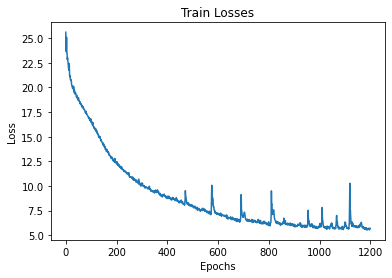

In [12]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.title("Train Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

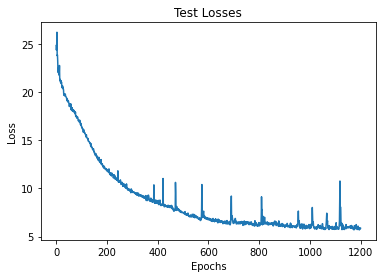

In [13]:
fig = plt.figure()
plt.plot(test_losses)
plt.title("Test Losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [ ]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [ ]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [ ]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [ ]:
x_samples.mean(0)

In [ ]:
X_test.mean(0)

In [ ]:
x_samples.std(0)

In [ ]:
X_test.std(0)

In [ ]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

In [ ]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [ ]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

In [ ]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(bos.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (held out dataset)")
    if i*4+j >= 13: 
        break 

plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [ ]:
X_test.shape

In [ ]:
x_samples.shape

In [ ]:
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [ ]:
x_samples.mean(0)

In [ ]:
X_test.mean(0)

In [ ]:
x_samples.std(0)

In [ ]:
X_test.std(0)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [ ]:
np.corrcoef(X_test, rowvar=False)[0]

In [ ]:
np.corrcoef(x_samples, rowvar=False)[0]

In [ ]:
np.corrcoef(X_test, rowvar=False)[1]

In [ ]:
np.corrcoef(x_samples, rowvar=False)[1]

In [ ]:
np.corrcoef(X_test, rowvar=False)[2]

In [ ]:
np.corrcoef(x_samples, rowvar=False)[2]

In [ ]:
np.corrcoef(X_test, rowvar=False)[3]

In [ ]:
np.corrcoef(x_samples, rowvar=False)[3]